In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col, when
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e781a7148bd0776036f44d3904cbe19aa4bbf9bf047c68b918a787fb66ca9aa6
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("Medicare Fraud Detection").getOrCreate()

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()


openjdk version "11.0.22" 2024-01-16
OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1)
OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)


In [ ]:
# Load dataset
df = spark.read.csv('/content/drive/MyDrive/Experiments/BDA/Medicare_Part_D_Prescribers_by_Provider_2021.csv', header=True, escape="\"")

In [ ]:
# Display schema
print("Schema:")
df.printSchema()

# Summary statistics for numeric columns
print("\nSummary Statistics for Numeric Columns:")
df.describe(numeric_cols).show()

# Count of rows
print("\nTotal Count of Rows:")
print(df.count())

# Display first few rows
print("\nFirst Few Rows:")
df.show(5)

Schema:
root
 |-- PRSCRBR_NPI: string (nullable = true)
 |-- Prscrbr_Last_Org_Name: string (nullable = true)
 |-- Prscrbr_First_Name: string (nullable = true)
 |-- Prscrbr_MI: string (nullable = true)
 |-- Prscrbr_Crdntls: string (nullable = true)
 |-- Prscrbr_Gndr: string (nullable = true)
 |-- Prscrbr_Ent_Cd: string (nullable = true)
 |-- Prscrbr_St1: string (nullable = true)
 |-- Prscrbr_St2: string (nullable = true)
 |-- Prscrbr_City: string (nullable = true)
 |-- Prscrbr_State_Abrvtn: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- Prscrbr_zip5: string (nullable = true)
 |-- Prscrbr_RUCA: string (nullable = true)
 |-- Prscrbr_RUCA_Desc: string (nullable = true)
 |-- Prscrbr_Cntry: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)
 |-- Prscrbr_Type_src: string (nullable = true)
 |-- Tot_Clms: double (nullable = true)
 |-- Tot_30day_Fills: double (nullable = true)
 |-- Tot_Drug_Cst: double (nullable = true)
 |-- Tot_Day_Suply: doubl

In [ ]:
# Number of rows
num_rows = df.count()

# Number of columns
num_columns = len(df.columns)

print("Shape of DataFrame: ({}, {})".format(num_rows, num_columns))

Shape of DataFrame: (1287454, 86)


In [ ]:
# Define numeric columns
numeric_cols = [
    "Tot_Clms", "Tot_30day_Fills", "Tot_Drug_Cst", "Tot_Day_Suply",
    "Tot_Benes", "GE65_Tot_Clms", "GE65_Tot_30day_Fills", "GE65_Tot_Drug_Cst",
    "GE65_Tot_Day_Suply", "GE65_Tot_Benes", "Brnd_Tot_Clms", "Brnd_Tot_Drug_Cst",
    "Gnrc_Tot_Clms", "Gnrc_Tot_Drug_Cst", "Othr_Tot_Clms", "Othr_Tot_Drug_Cst",
    "MAPD_Tot_Clms", "MAPD_Tot_Drug_Cst", "PDP_Tot_Clms", "PDP_Tot_Drug_Cst",
    "LIS_Tot_Clms", "LIS_Drug_Cst", "NonLIS_Tot_Clms", "NonLIS_Drug_Cst",
    "Opioid_Tot_Clms", "Opioid_Tot_Drug_Cst", "Opioid_Tot_Suply", "Opioid_Tot_Benes",
    "Opioid_LA_Tot_Clms", "Opioid_LA_Tot_Drug_Cst", "Opioid_LA_Tot_Suply",
    "Opioid_LA_Tot_Benes", "Antbtc_Tot_Clms", "Antbtc_Tot_Drug_Cst", "Antbtc_Tot_Benes",
    "Antpsyct_GE65_Tot_Clms", "Antpsyct_GE65_Tot_Drug_Cst", "Antpsyct_GE65_Tot_Benes",
    "Bene_Avg_Age", "Bene_Age_LT_65_Cnt", "Bene_Age_65_74_Cnt", "Bene_Age_75_84_Cnt",
    "Bene_Age_GT_84_Cnt", "Bene_Feml_Cnt", "Bene_Male_Cnt", "Bene_Race_Wht_Cnt",
    "Bene_Race_Black_Cnt", "Bene_Race_Api_Cnt", "Bene_Race_Hspnc_Cnt",
    "Bene_Race_Natind_Cnt", "Bene_Race_Othr_Cnt", "Bene_Dual_Cnt", "Bene_Ndual_Cnt",
    "Bene_Avg_Risk_Scre"
]

In [ ]:
# Get list of categorical columns
categorical_cols = [col_name for col_name, data_type in df.dtypes if data_type == "string"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Convert string columns to FloatType
for col_name in numeric_cols:
    df = df.withColumn(col_name, df[col_name].cast(FloatType()))

In [ ]:
# Fill null values with mean
for column in numeric_cols:
    mean_value = df.select(mean(col(column))).collect()[0][0]
    df = df.withColumn(column, when(col(column).isNull(), mean_value).otherwise(col(column)))

In [ ]:
# Create feature vector
vector_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features", handleInvalid="skip")

In [ ]:
# Define logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="is_fraud")

In [ ]:
# Create pipeline
pipeline = Pipeline(stages=[vector_assembler, lr])

In [ ]:
# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)  # 80% training, 20% testing

In [ ]:
# Set a threshold for number of claims for fraud detection
threshold = 1000  # Adjust this threshold based on your criteria

In [ ]:
# Create a new column "is_fraud" based on "Tot_Clms" and the threshold
df = df.withColumn("is_fraud", when(df["Tot_Clms"] > threshold, 1).otherwise(0))

In [ ]:
# Train model
model = pipeline.fit(train_data)

In [ ]:
# Make predictions on the test data
predictions = model.transform(test_data)

In [ ]:
# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderROC")
area_under_curve = evaluator.evaluate(predictions)

In [ ]:
# Evaluate the model using MulticlassClassificationEvaluator for accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

In [ ]:
# Print evaluation metrics
print("Area Under ROC Curve: {:.4f}".format(area_under_curve))
print("Accuracy: {:.4f}".format(accuracy))

Area Under ROC Curve: 1.0000
Accuracy: 0.9984


In [ ]:
# Compute correlation matrix for numeric features
numeric_data = df.select(numeric_cols).toPandas()
correlation_matrix = numeric_data.corr()

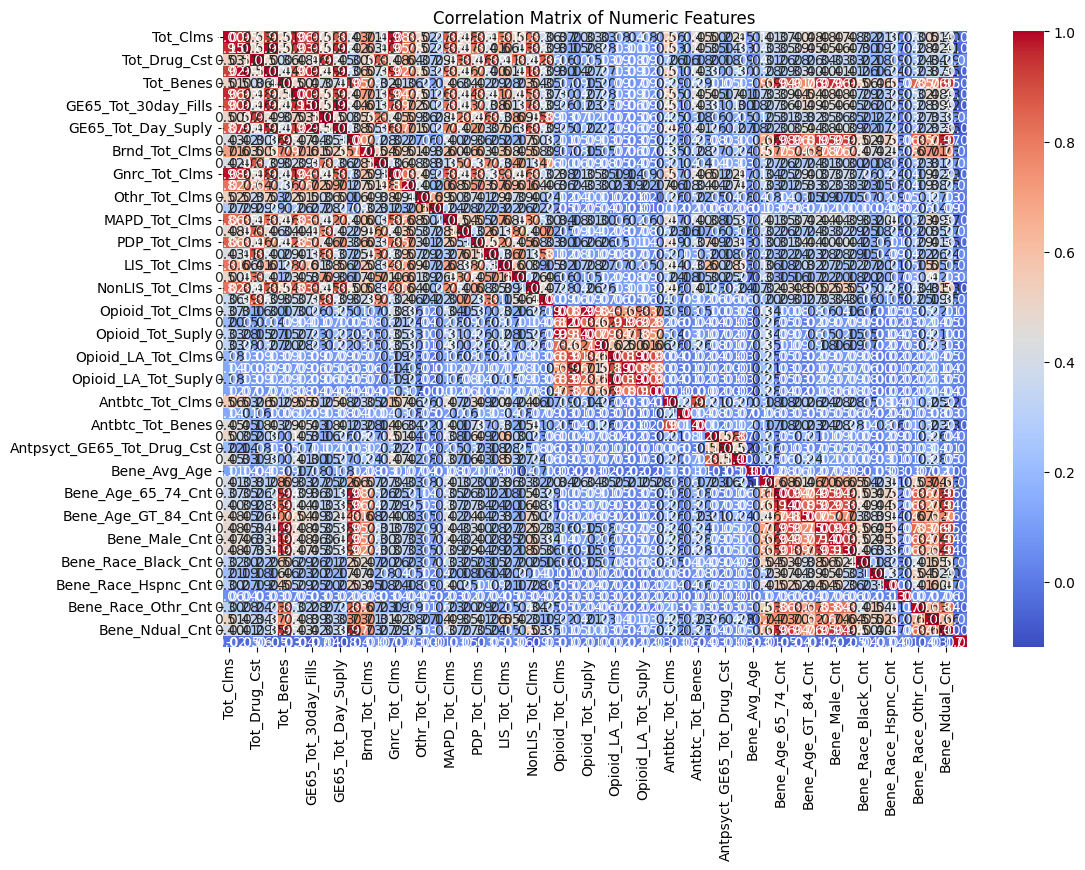

In [ ]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [ ]:
from pyspark.sql import Row

# Define an example data point
example_data = Row(
    Tot_Clms=100,
    Tot_30day_Fills=50,
    Tot_Drug_Cst=5000,
    Tot_Day_Suply=2000,
    Tot_Benes=50,
    GE65_Tot_Clms=70,
    GE65_Tot_30day_Fills=30,
    GE65_Tot_Drug_Cst=3000,
    GE65_Tot_Day_Suply=1500,
    GE65_Tot_Benes=20,
    Brnd_Tot_Clms=40,
    Brnd_Tot_Drug_Cst=3000,
    Gnrc_Tot_Clms=60,
    Gnrc_Tot_Drug_Cst=2000,
    Othr_Tot_Clms=50,
    Othr_Tot_Drug_Cst=2000,
    MAPD_Tot_Clms=30,
    MAPD_Tot_Drug_Cst=1500,
    PDP_Tot_Clms=20,
    PDP_Tot_Drug_Cst=1000,
    LIS_Tot_Clms=40,
    LIS_Drug_Cst=3000,
    NonLIS_Tot_Clms=60,
    NonLIS_Drug_Cst=2000,
    Opioid_Tot_Clms=10,
    Opioid_Tot_Drug_Cst=500,
    Opioid_Tot_Suply=100,
    Opioid_Tot_Benes=5,
    Opioid_LA_Tot_Clms=5,
    Opioid_LA_Tot_Drug_Cst=200,
    Opioid_LA_Tot_Suply=50,
    Opioid_LA_Tot_Benes=2,
    Antbtc_Tot_Clms=20,
    Antbtc_Tot_Drug_Cst=1000,
    Antbtc_Tot_Benes=10,
    Antpsyct_GE65_Tot_Clms=15,
    Antpsyct_GE65_Tot_Drug_Cst=500,
    Antpsyct_GE65_Tot_Benes=5,
    Bene_Avg_Age=70,
    Bene_Age_LT_65_Cnt=20,
    Bene_Age_65_74_Cnt=15,
    Bene_Age_75_84_Cnt=10,
    Bene_Age_GT_84_Cnt=5,
    Bene_Feml_Cnt=30,
    Bene_Male_Cnt=20,
    Bene_Race_Wht_Cnt=40,
    Bene_Race_Black_Cnt=10,
    Bene_Race_Api_Cnt=5,
    Bene_Race_Hspnc_Cnt=10,
    Bene_Race_Natind_Cnt=2,
    Bene_Race_Othr_Cnt=3,
    Bene_Dual_Cnt=25,
    Bene_Ndual_Cnt=25,
    Bene_Avg_Risk_Scre=0.5
)

# Convert the example data to a DataFrame
example_df = spark.createDataFrame([example_data])

# Make predictions on the example data using the trained model
predictions = model.transform(example_df)

# Show the predictions
predictions.select("prediction", "probability").show()

+----------+-----------+
|prediction|probability|
+----------+-----------+
|       0.0|  [1.0,0.0]|
+----------+-----------+

